In [1]:
%load_ext autoreload
%autoreload 2

from src.experiment import get_fallacy_identification_df
from src.analysis import score_fallacy_identification, get_fallacy_identification_accuracies, get_fallacy_identification_grouped_accuracies
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()


# Fallacy Identification

## Experiment 1: Fallacy Identification with zero-shot Prompt

In [2]:
df_fallacies = get_fallacy_identification_df()

[2024-10-17 17:27:14] Loaded existing fallacy identification dataframe from CSV.


In [3]:
score_fallacy_identification(df_fallacies)

df_fallacies.head()

,step,entity,fallacy,label,category,type,gpt_4o_response,gpt_4_response,gpt_4o_mini_response,sonnet_3_5_response,gemini_1_5_pro_response,gemini_1_5_flash_response,gpt_4_score,gpt_4o_score,gpt_4o_mini_score,sonnet_3_5_score,gemini_1_5_pro_score,gemini_1_5_flash_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No,No,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No,No,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No,No,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,Yes,No,1,1,1,1,0,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,No,No,1,1,1,1,1,1


In [4]:
df_fallacies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   step                       4640 non-null   object
 1   entity                     4640 non-null   object
 2   fallacy                    4640 non-null   object
 3   label                      4640 non-null   int64 
 4   category                   4640 non-null   object
 5   type                       4640 non-null   object
 6   gpt_4o_response            4640 non-null   object
 7   gpt_4_response             4640 non-null   object
 8   gpt_4o_mini_response       4640 non-null   object
 9   sonnet_3_5_response        4640 non-null   object
 10  gemini_1_5_pro_response    4640 non-null   object
 11  gemini_1_5_flash_response  4640 non-null   object
 12  gpt_4_score                4640 non-null   Int64 
 13  gpt_4o_score               4640 non-null   Int64 
 14  gpt_4o_m

### Overall Scores

In [5]:
df_accuracies = get_fallacy_identification_accuracies(df_fallacies)
df_accuracies = df_accuracies.sort_values('Accuracy', ascending=False)
df_accuracies

,LLM,Accuracy
0,GPT-4,89.8
4,Gemini 1.5 Pro,88.7
1,GPT-4o,88.4
2,GPT-4o Mini,86.9
3,Claude Sonnet 3.5,83.6
5,Gemini 1.5 Flash,83.2


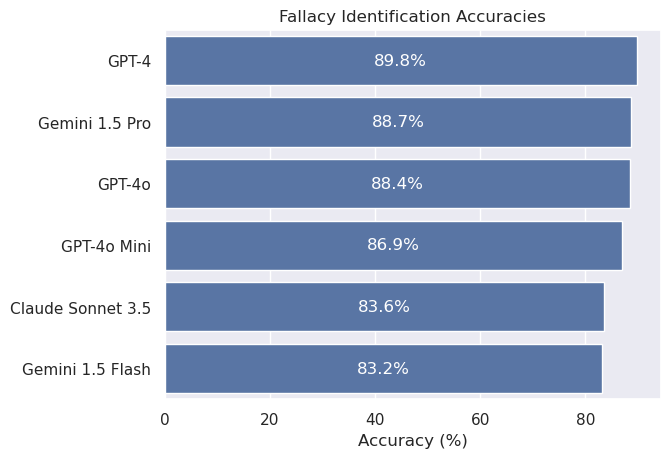

In [6]:
ax = sns.barplot(x='Accuracy', y='LLM', data=df_accuracies)
plt.title('Fallacy Identification Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('')

# Add annotations inside the bars
for i, v in enumerate(df_accuracies['Accuracy']):
    ax.text(v/2, i, f'{v:.1f}%',  ha='center', va='center', color='white')

plt.show()


### Scores by fallacy type

In [7]:
df_category_accuracies = get_fallacy_identification_grouped_accuracies(df_fallacies, ['category'])
df_category_accuracies

,formal,informal
GPT-4,88.3,89.9
GPT-4o,85.6,88.7
GPT-4o Mini,79.6,87.7
Claude Sonnet 3.5,85.8,83.4
Gemini 1.5 Pro,87.7,88.8
Gemini 1.5 Flash,82.5,83.3


In [8]:
df_type_accuracies = get_fallacy_identification_grouped_accuracies(df_fallacies, ['category', 'type'])
df_type_accuracies

formal                                             \
                  probabilistic propositional quantificational syllogistic   
GPT-4                      86.2          93.3             84.2        88.8   
GPT-4o                     87.5          83.3             80.8        90.0   
GPT-4o Mini                77.5          80.0             74.2        84.4   
Claude Sonnet 3.5          81.2          86.7             80.8        91.2   
Gemini 1.5 Pro             88.8          85.0             85.8        90.6   
Gemini 1.5 Flash           76.2          81.7             81.7        86.9   

                   informal                                          \
                  ambiguity inappropriate presumption inconsistency   
GPT-4                  84.7                      86.9          85.0   
GPT-4o                 85.0                      87.0          88.3   
GPT-4o Mini            84.3                      87.0          86.7   
Claude Sonnet 3.5      78.7                      84.3          81.7   
Gemini 1.5 Pro         85.7                      88.1          80.0   
Gemini 1.5 Flash       80.0                      84.4          81.7   

                                             
                  insufficiency irrelevance  
GPT-4                      94.0        90.2  
GPT-4o                     92.4        87.9  
GPT-4o Mini                91.1        86.3  
Claude Sonnet 3.5          86.9        81.2  
Gemini 1.5 Pro             92.1        87.8  
Gemini 1.5 Flash           86.6        80.7